<a href="https://colab.research.google.com/github/ajuni-sohota/Airbnb-Price-Predictions-SF/blob/main/Airbnb_Price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from ast import literal_eval

%matplotlib inline

import xgboost as xgb
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import learning_curve, ShuffleSplit, RepeatedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [ ]:
pip install dataframe_image

     |████████████████████████████████| 1.1 MB 7.6 MB/s 
     |████████████████████████████████| 192 kB 37.1 MB/s 
     |████████████████████████████████| 271 kB 34.4 MB/s 
     |████████████████████████████████| 160 kB 40.3 MB/s 


In [ ]:
df_listings = pd.read_csv("listings.csv")
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,2.019100e+13,10/14/19,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,* No Pets - even visiting guests for a short t...,NaN,NaN,https://a0.muscache.com/im/pictures/b7c2a199-4...,NaN,1169,https://www.airbnb.com/users/show/1169,Holly,7/31/08,"San Francisco, California, United States",We are a family with 2 boys born in 2009 and 2...,within a day,100%,NaN,t,https://a0.muscache.com/im/pictures/efdad96a-3...,https://a0.muscache.com/im/pictures/efdad96a-3...,Duboce Triangle,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Duboce Triangle,Western Addition,...,$25.00,1,30,1,1,30,30,1.0,30.0,2 months ago,t,3,8,16,85,10/14/19,217,52,7/23/09,9/21/19,97.0,10.0,10.0,10.0,10.0,10.0,9.0,t,STR-0001256,"{""SAN FRANCISCO""}",f,f,moderate,f,f,1,1,0,0,1.74
1,3850,https://www.airbnb.com/rooms/3850,2.019100e+13,10/14/19,Charming room for two,Your own private room plus access to a shared ...,This room can fit two people. Nobody else will...,Your own private room plus access to a shared ...,none,"This is a quiet, safe neighborhood on a substa...",House Rule footnotes: 1.\tI don’t allow check ...,Public transit service to my house is outstand...,"During the hours of 7:00 to 22:00, your access...","I live at the house in my own bedroom, and I w...",Airbnb has no default house rules that hosts c...,NaN,NaN,https://a0.muscache.com/im/pictures/b6e97d2a-1...,NaN,4921,https://www.airbnb.com/users/show/4921,Kevin,12/8/08,"San Francisco, California, United States",I am a retired software developer now raising ...,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/97d29791-d...,https://a0.muscache.com/im/pictures/97d29791-d...,Inner Sunset,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"San Francisco, CA, United States",Inner Sunset,Inner Sunset,...,$20.00,1,5,1,1,5,5,1.0,5.0,3 days ago,t,5,32,62,62,10/14/19,160,36,7/16/09,9/30/19,94.0,10.0,10.0,10.0,10.0,10.0,10.0,t,STR-0000346,"{""SAN FRANCISCO""}",f,f,strict_14_with_grace_period,f,f,3,0,3,0,1.28
2,5858,https://www.airbnb.com/rooms/5858,2.019100e+13,10/14/19,Creative Sanctuary,NaN,We live in 

In [ ]:
null_columns=df_listings.columns[df_listings.isnull().any()]
df_listings[null_columns].isnull().sum()

summary                          225
space                           1134
description                       50
neighborhood_overview           2018
notes                           3108
transit                         2415
access                          2911
interaction                     2624
house_rules                     2176
thumbnail_url                   8111
medium_url                      8111
xl_picture_url                  8111
host_name                          8
host_since                         8
host_location                     13
host_about                      2031
host_response_time               927
host_response_rate               927
host_acceptance_rate            8111
host_is_superhost                  8
host_thumbnail_url                 8
host_picture_url                   8
host_neighbourhood               525
host_listings_count                8
host_total_listings_count          8
host_has_profile_pic               8
host_identity_verified             8
n

In [ ]:
df_listings.shape

(8111, 106)

In [ ]:
# General statistics of the data
df_listings.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.111000e+03,8.111000e+03,0.0,0.0,0.0,8.111000e+03,0.0,8103.000000,8103.000000,0.0,8111.000000,8111.000000,8111.000000,8099.000000,8107.000000,8102.000000,124.000000,8111.000000,8.111000e+03,8.111000e+03,8.111000e+03,8.111000e+03,8.111000e+03,8.111000e+03,8.111000e+03,8.111000e+03,8111.000000,8111.000000,8111.000000,8111.000000,8111.000000,8111.000000,6460.000000,6457.000000,6457.000000,6456.000000,6458.000000,6456.000000,6456.000000,8111.000000,8111.000000,8111.000000,8111.000000,6506.000000
mean,2.024561e+07,2.019100e+13,NaN,NaN,NaN,6.159690e+07,NaN,90.421079,90.421079,NaN,37.766054,-122.430107,3.160769,1.395975,1.345874,1.744754,1046.177419,1.718407,1.234526e+04,1.284597e+04,1.234509e+04,1.235125e+04,2.775902e+05,2.775928e+05,1.235001e+04,2.775923e+05,9.255825,22.885341,39.619529,159.278881,45.203181,13.712736,95.421517,9.752207,9.603686,9.847584,9.817745,9.682776,9.375155,22.329799,18.201085,2.910985,0.496979,1.873298
std,1.228565e+07,0.000000e+00,NaN,NaN,NaN,8.017417e+07,NaN,324.526784,324.526784,NaN,0.022937,0.026967,1.896988,0.923213,0.925298,1.158799,827.297727,1.334492,1.110357e+06,1.110352e+06,1.110357e+06,1.110357e+06,2.387044e+07,2.387044e+07,1.110357e+06,2.387044e+07,10.586687,21.459500,32.125850,134.093744,78.437987,22.523539,7.571031,0.732872,0.839768,0.593539,0.659274,0.715906,0.879174,54.369225,53.333669,6.807334,2.669129,2.096730
min,9.580000e+02,2.019100e+13,NaN,NaN,NaN,2.800000e+01,NaN,0.000000,0.000000,NaN,37.704630,-122.513060,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,8.905668e+06,2.019100e+13,NaN,NaN,NaN,4.386571e+06,NaN,1.000000,1.000000,NaN,37.751450,-122.442830,2.000000,1.000000,1.000000,1.000000,500.000000,1.000000,2.000000e+00,2.900000e+01,2.000000e+00,2.000000e+00,2.900000e+01,2.900000e+01,2.000000e+00,2.900000e+01,0.000000,0.000000,6.000000,28.000000,1.000000,0.000000,95.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.300000
50%,2.161057e+07,2.019100e+13,NaN,NaN,NaN,2.178983e+07,NaN,2.000000,2.000000,NaN,37.769150,-122.424650,2.000000,1.000000,1.000000,1.000000,851.000000,1.000000,4.000000e+00,1.800000e+02,4.000000e+00,5.000000e+00,1.800000e+02,1.800000e+02,4.000000e+00,1.800000e+02,5.000000,19.000000,38.000000,133.000000,10.000000,2.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,0.000000,0.000000,1.010000
75%,3.120025e+07,2.019100e+13,NaN,NaN,NaN,1.000763e+08,NaN,12.000000,12.000000,NaN,37.785670,-122.410615,4.000000,1.500000,2.000000,2.000000,1492.500000,2.000000,3.000000e+01,1.125000e+03,3.000000e+01,3.000000e+01,1.125000e+03,1.125000e+03,3.000000e+01,1.125000e+03,17.000000,42.000000,69.500000,300.000000,54.000000,18.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.000000,0.000000,2.840000
max,3.935418e+07,2.019100e+1

In [ ]:
# Displaying all columns
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,2.019100e+13,10/14/19,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,Due to the fact that we have children and a do...,*Public Transportation is 1/2 block away. *Ce...,*Full access to patio and backyard (shared wit...,A family of 4 lives upstairs with their dog. N...,* No Pets - even visiting guests for a short t...,NaN,NaN,https://a0.muscache.com/im/pictures/b7c2a199-4...,NaN,1169,https://www.airbnb.com/users/show/1169,Holly,7/31/08,"San Francisco, California, United States",We are a family with 2 boys born in 2009 and 2...,within a day,100%,NaN,t,https://a0.muscache.com/im/pictures/efdad96a-3...,https://a0.muscache.com/im/pictures/efdad96a-3...,Duboce Triangle,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"San Francisco, CA, United States",Duboce Triangle,Western Addition,NaN,San Francisco,CA,94117,San Francisco,"San Francisco, CA",US,United States,37.76931,-122.43386,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",NaN,$170.00,"$1,120.00","$4,200.00",$100.00,$100.00,2,$25.00,1,30,1,1,30,30,1.0,30.0,2 months ago,t,3,8,16,85,10/14/19,217,52,7/23/09,9/21/19,97.0,10.0,10.0,10.0,10.0,10.0,9.0,t,STR-0001256,"{""SAN FRANCISCO""}",f,f,moderate,f,f,1,1,0,0,1.74
1,3850,https://www.airbnb.com/rooms/3850,2.019100e+13,10/14/19,Charming room for two,Your own private room plus access to a shared ...,This room can fit two people. Nobody else will...,Your own private room plus access to a shared ...,none,"This is a quiet, safe neighborhood on a substa...",House Rule footnotes: 1.\tI don’t allow check ...,Public transit service to my house is outstand...,"During the hours of 7:00 to 22:00, your access...","I live at the house in my own bedroom, and I w...",Airbnb has no default house rules that hosts c...,NaN,NaN,https://a0.muscache.com/im/pictures/b6e97d2a-1...,NaN,4921,https://www.airbnb.com/users/show/4921,Kevin,12/8/08,"San Francisco, California, United States",I am a retired software developer now raising ...,within an hour,100%

In [ ]:
# Dataframe columns information
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Columns: 106 entries, id to reviews_per_month
dtypes: float64(24), int64(20), object(62)
memory usage: 6.6+ MB


In [ ]:
def drop_columns(df):
    
    """
    Dropping Columns that aren't needed and
    also removing columns with 70% or more of 
    missing data in the column
    
    Parameters:
    
    Dataframe
    
    Returns:
    
    Dataframe
    
    """

    regex_list = ['url','scrape','first_review','last_review','cancellation_policy','requires']
    
    for i in regex_list:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
        
    df = df.drop(columns=['id', 'name', 'summary', 'latitude', 'longitude',
                          'space', 'description', 'experiences_offered', 'neighborhood_overview', 
                          'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_id', 
                          'host_name', 'host_since', 'host_location', 'host_about',
                          'host_neighbourhood', 'host_listings_count', 'host_verifications', 
                          'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 
                          'is_location_exact', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 
                          'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                          'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 
                          'has_availability', 'availability_30', 'availability_60', 'availability_90', 
                          'availability_365', 'license', 'jurisdiction_names', 'is_business_travel_ready', 
                          'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                          'calculated_host_listings_count_private_rooms', 
                          'calculated_host_listings_count_shared_rooms'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df.columns[df.isnull().mean()>0.70])
    df = df.drop(list(col_nulls), axis=1)
    
    return df

In [ ]:
def onehot_df(df, variable, unique_items):
    
    """
    Creates one hot encoding for the specified column
    using the unique items specified
    
    Parameters:
    
    Dataframe, variable(string), unique_items(list)
    
    Returns:
    
    Dataframe
    
    """
    
    item_lists = df[variable]
    
    # Loop through all the labels
    for i, label in enumerate(unique_items):
        
        # Creating new column for each label
        df[variable+'_'+label] = item_lists.apply(lambda x: 1 if label in x else 0)
    
    # Removing old column
    del df[variable]
            
    # Return the results as a dataframe
    return df

In [ ]:
def to_1D(series):
    
    """
    Creates a 1D array
    
    Paramters:
    
    Series
    
    Returns:
    
    Array
    
    """
    
    return pd.Series([x for _list in series for x in _list])

In [ ]:
# Dropping unwanted columns
df_listings = drop_columns(df_listings)

In [ ]:
df_listings.head()

,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,zipcode,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,within a day,100%,t,1.0,t,t,"San Francisco, CA, United States",Western Addition,94117,United States,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",$170.00,$100.00,$100.00,2,$25.00,217,52,97.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,f,1.74
1,within an hour,100%,t,2.0,t,t,"San Francisco, CA, United States",Inner Sunset,94131,United States,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Breakfast,""Free street ...",$99.00,$0.00,$10.00,2,$20.00,160,36,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,1.28
2,within a day,80%,f,2.0,t,t,"San Francisco, CA, United States",Bernal Heights,94110,United States,Apartment,Entire home/apt,5,1.0,2.0,3.0,Real Bed,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",$235.00,NaN,$100.00,2,$0.00,111,0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,f,0.87
3,within an hour,86%,t,10.0,t,t,"San Francisco, CA, United States",Haight Ashbury,94117,United States,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",$65.00,$200.00,$50.00,1,$12.00,18,1,86.0,8.0,8.0,9.0,9.0,9.0,8.0,f,f,f,0.15
4,within an hour,86%,t,10.0,t,t,"San Francisco, CA, United States",Haight Ashbury,94117,United States,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",$65.00,$200.00,$50.00,1,$12.00,8,0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,f,f,f,0.13


In [ ]:
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [ ]:
# Change the prices to floats for correlation interpretation
df_listings['price'] = df_listings['price'].apply(clean_currency).astype('float')
df_listings['security_deposit'] = df_listings['security_deposit'].apply(clean_currency).astype('float')
df_listings['cleaning_fee'] = df_listings['cleaning_fee'].apply(clean_currency).astype('float')
df_listings['extra_people'] = df_listings['extra_people'].apply(clean_currency).astype('float')

df_listings.head()

,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,zipcode,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,within a day,100%,t,1.0,t,t,"San Francisco, CA, United States",Western Addition,94117,United States,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",170.0,100.0,100.0,2,25.0,217,52,97.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,f,1.74
1,within an hour,100%,t,2.0,t,t,"San Francisco, CA, United States",Inner Sunset,94131,United States,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Breakfast,""Free street ...",99.0,0.0,10.0,2,20.0,160,36,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,1.28
2,within a day,80%,f,2.0,t,t,"San Francisco, CA, United States",Bernal Heights,94110,United States,Apartment,Entire home/apt,5,1.0,2.0,3.0,Real Bed,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",235.0,NaN,100.0,2,0.0,111,0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,f,0.87
3,within an hour,86%,t,10.0,t,t,"San Francisco, CA, United States",Haight Ashbury,94117,United States,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",65.0,200.0,50.0,1,12.0,18,1,86.0,8.0,8.0,9.0,9.0,9.0,8.0,f,f,f,0.15
4,within an hour,86%,t,10.0,t,t,"San Francisco, CA, United States",Haight Ashbury,94117,United States,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",65.0,200.0,50.0,1,12.0,8,0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,f,f,f,0.13


In [ ]:
# Change t/f into boolean 1/0

cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable",
       "require_guest_profile_picture", "require_guest_phone_verification"]

for x in cols:
    df_listings[cols] = df_listings[cols].replace('t', 1, regex = True)
    df_listings[cols] = df_listings[cols].replace('f', 0, regex = True)

df_listings.head()

,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,zipcode,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,within a day,100%,1.0,1.0,1.0,1.0,"San Francisco, CA, United States",Western Addition,94117,United States,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",170.0,100.0,100.0,2,25.0,217,52,97.0,10.0,10.0,10.0,10.0,10.0,9.0,0,0,0,1.74
1,within an hour,100%,1.0,2.0,1.0,1.0,"San Francisco, CA, United States",Inner Sunset,94131,United States,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Breakfast,""Free street ...",99.0,0.0,10.0,2,20.0,160,36,94.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,1.28
2,within a day,80%,0.0,2.0,1.0,1.0,"San Francisco, CA, United States",Bernal Heights,94110,United States,Apartment,Entire home/apt,5,1.0,2.0,3.0,Real Bed,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",235.0,NaN,100.0,2,0.0,111,0,98.0,10.0,10.0,10.0,10.0,10.0,9.0,0,0,0,0.87
3,within an hour,86%,1.0,10.0,1.0,1.0,"San Francisco, CA, United States",Haight Ashbury,94117,United States,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",65.0,200.0,50.0,1,12.0,18,1,86.0,8.0,8.0,9.0,9.0,9.0,8.0,0,0,0,0.15
4,within an hour,86%,1.0,10.0,1.0,1.0,"San Francisco, CA, United States",Haight Ashbury,94117,United States,Apartment,Private room,2,4.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free street parking...",65.0,200.0,50.0,1,12.0,8,0,93.0,9.0,9.0,10.0,10.0,9.0,9.0,0,0,0,0.13


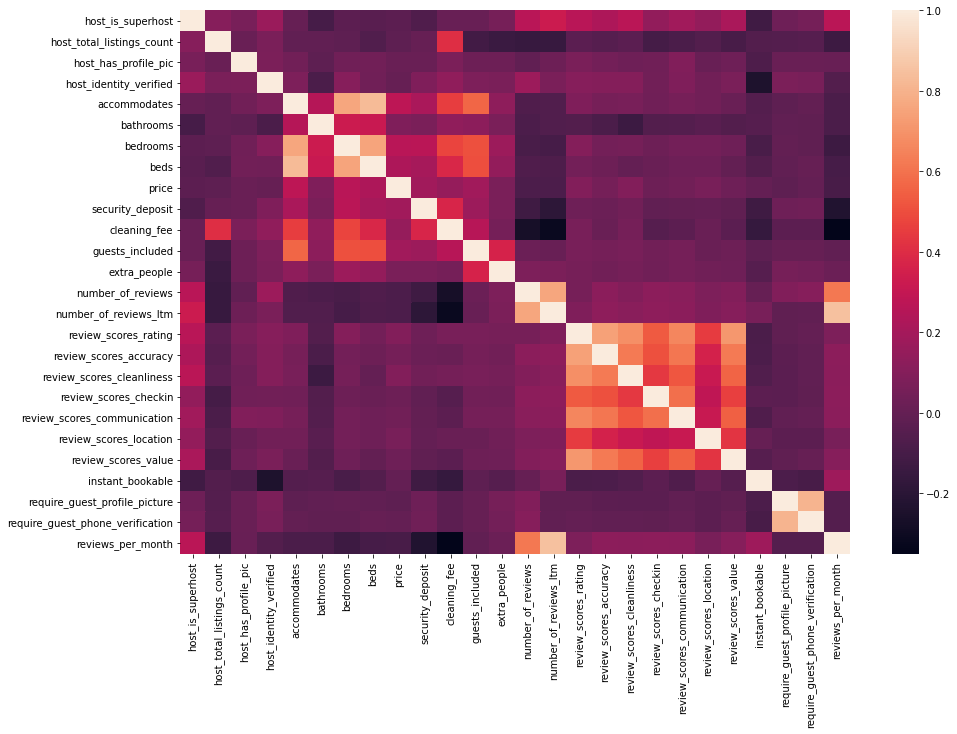

In [ ]:
# Finding the columns that have an correlation with the price column
# calculate the correlation matrix
corr = df_listings.corr()

plt.figure(figsize = (15,10))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [ ]:
# Checking labels for the object type data
for col in df_listings.select_dtypes(include=['object']).columns:
    print(col, ': ', len(df_listings[col].unique()), 'labels')

host_response_time :  5 labels
host_response_rate :  44 labels
street :  12 labels
neighbourhood_cleansed :  37 labels
zipcode :  45 labels
country :  1 labels
property_type :  26 labels
room_type :  4 labels
bed_type :  5 labels
amenities :  6932 labels


In [ ]:
# Checking Property Type labels
df_property_type = df_listings["property_type"].value_counts()
df_property_type

Apartment             3243
House                 2314
Condominium            892
Guest suite            577
Boutique hotel         267
Hotel                  157
Townhouse              142
Serviced apartment     121
Hostel                  92
Loft                    88
Bed and breakfast       43
Guesthouse              41
Aparthotel              41
Other                   24
Bungalow                17
Resort                  14
Cottage                 12
Villa                   10
Castle                   4
Tiny house               3
Cabin                    3
Earth house              2
In-law                   1
Dome house               1
Camper/RV                1
Hut                      1
Name: property_type, dtype: int64

In [ ]:
# Creating new property type column
df_listings["property_type"] = df_listings["property_type"].str.split().str[-1]

In [ ]:
# Cleaning the amenities
df_listings.amenities = df_listings.amenities.str.replace("[{}]", "").str.replace('"', "")
df_listings['amenities'].head()

0    TV,Cable TV,Internet,Wifi,Kitchen,Pets live on...
1    Internet,Wifi,Kitchen,Breakfast,Free street pa...
2    Internet,Wifi,Kitchen,Heating,Family/kid frien...
3    TV,Internet,Wifi,Kitchen,Free street parking,H...
4    TV,Internet,Wifi,Kitchen,Free street parking,H...
Name: amenities, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(df_listings['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)

In [ ]:
# concat df_amenities to df_listings
df_listings = pd.concat([df_listings, df_amenities], axis=1, join='inner')

In [ ]:
# Creating the top 20 property types
df_new_property_top_20 = pd.DataFrame(df_listings["property_type"].value_counts().head(20)).index

df_new_property_top_20

Index(['Apartment', 'House', 'Condominium', 'suite', 'hotel', 'Hotel',
       'Townhouse', 'apartment', 'Hostel', 'Loft', 'breakfast', 'Aparthotel',
       'Guesthouse', 'Other', 'Bungalow', 'Resort', 'Cottage', 'Villa',
       'house', 'Castle'],
      dtype='object')

In [ ]:
# Confirming the shape of the df_listings
df_listings.shape

(8111, 221)

In [ ]:
df_listings.head()

,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,zipcode,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,toilet,24-hour check-in,accessible-height bed,accessible-height toilet,air conditioning,air purifier,amazon echo,baby bath,baby monitor,babysitter recommendations,balcony,bath towel,bathroom essentials,bathtub,bathtub with bath chair,bbq grill,beach essentials,beach view,beachfront,bed linens,bedroom comforts,bidet,body soap,breakfast,breakfast table,building staff,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),ceiling fan,central air conditioning,changing table,children’s books and toys,children’s dinnerware,cleaning before checkout,coffee maker,convection oven,cooking basics,crib,day bed,disabled parking spot,dishes and silverware,dishwasher,dog(s),doorman,double oven,dryer,dvd player,electric profiling bed,elevator,en suite bathroom,espresso machine,essentials,ethernet connection,ev charger,exercise equipment,extra pillows and blankets,extra space around bed,family/kid friendly,fax machine,fire extinguisher,fire pit,fireplace guards,firm mattress,first aid kit,fixed grab bars for shower,fixed grab bars for toilet,flat path to guest entrance,formal dining area,free parking on premises,free street parking,full kitchen,game console,garden or backyard,gas oven,ground floor access,gym,hair dryer,hammock,handheld shower head,hangers,hbo go,heat lamps,heated floors,heated towel rack,heating,high chair,high-resolution computer monitor,host greets you,hot tub,hot water,hot water kettle,indoor fireplace,internet,iron,jetted tub,keypad,kitchen,kitchenette,lake access,laptop friendly workspace,lock on bedroom door,lockbox,long term stays allowed,luggage dropoff allowed,memory foam mattress,microwave,mini fridge,mountain view,mudroom,murphy bed,netflix,no stairs or steps to enter,other,other pet(s),outdoor parking,outdoor seating,outlet covers,oven,pack ’n play/travel crib,paid parking off premises,paid parking on premises,patio or balcony,pets allowed,pets live on this property,pillow-top mattress,pocket wifi,pool,printer,private bathroom,private entrance,private hot tub,private living room,projector and screen,rain shower,refrigerator,room-darkening shades,safety card,self check-in,shampoo,shared gym,shared hot tub,shared pool,shower chair,single level home,ski-in/ski-out,smart lock,smart tv,smoke detector,smoking allowed,soaking tub,sound system,stair gates,stand alone steam shower,standing valet,steam oven,step-free shower,stove,suitable for events,sun loungers,table corner guards,tennis court,terrace,toilet paper,touchless faucets,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,tv,walk-in shower,warming drawer,washer,washer / dryer,waterfront,well-lit path to entrance,wheelchair accessible,wide clearance to shower,wide doorway to guest bathroom,wide entrance,wide entrance for guests,wide entryway,wide hallways,wifi,window guards,wine cooler
0,within a day,100%,1.0,1.0,1.0,1.0,"San Francisco, CA, United States",Western Addition,94117,United States,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"TV,Cable TV,Internet,Wifi,Kitchen,Pets live on...",170.0,100.0,100.0,2,25.0,217,52,97.0,10.0,10.0,10.0,10.0,10.0,9.0,0,0,0,1.74,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,

<b>Train Test Split</b>

In [ ]:
# Removing any rows with NaN values
df_listings = df_listings.dropna()

In [ ]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df_listings = df_listings[df_listings['price'] != 0]

In [ ]:
# One Hot Encoding for all Object columns
cat_df_listings = df_listings.select_dtypes(include=['object'])


In [ ]:
cat_df_listings_new = ('cat_df_listings', OneHotEncoder(handle_unknown = 'ignore'))

In [ ]:
df_listings = df_listings.drop(columns = cat_df_listings)

In [ ]:
# Log transforming columns

for col in df_listings:
    df_listings[col] = df_listings[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df_listings[col] = np.log(df_listings[col])

In [ ]:
# Verify there are no more object dtypes
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634 entries, 0 to 8042
Columns: 211 entries, host_is_superhost to wine cooler
dtypes: float64(211)
memory usage: 7.5 MB


In [ ]:
# Extract features and labels
X = df_listings.drop("price", axis=1) # drop labels for training set
y = df_listings["price"].copy()

# List of features for later use
X_columns = list(X.columns)

In [ ]:
# Applying the train / test split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [ ]:
# Confirming the rows and columns are the 
# same for train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3243, 210)
(1391, 210)
(3243,)
(1391,)


<b> Creating the data pipeline


In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    """
    A class to select numerical or categorical columns
    
    """
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return X[self.attribute_names]

In [ ]:
# Selecting required dataframe for transformation
X_train_num = X_train.select_dtypes(include=['float64', 'int64'])
X_train_cat = X_train.select_dtypes(include=['object'])

In [ ]:
# Columns of dataframes selected
num_attribs = list(X_train_num.columns)
cat_attribs = list(X_train_cat.columns)

In [ ]:
# Category pipeline, using one hot encoding
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))])

In [ ]:
# Number pipeline, adding any missing data with median and 
# applying scaler to the data
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler())
    ])

In [ ]:
# Joining category and numerical pipelines
full_pipeline = Pipeline([
       ('features', FeatureUnion([
                    ("num_pipeline", num_pipeline),
                    ("cat_pipeline", cat_pipeline)
                ])
        )])

In [ ]:
# Transforming train and test data
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [ ]:
# Confiming the layout after transformation
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(3243, 210)
(1391, 210)


<b> Model Evaluation

In [ ]:
def base_models(model, X_train, X_test, y_train, y_test):
    
    """
    Function for fitting and predicting with the quired model
    
    Parameters:
    
    model, X_train, X_test, y_train, y_test
    
    Returns:
    
    RMSE
    
    """
    
    start_time = time.time()
   
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predict_train)
    rmse_train = np.sqrt(mse_train)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    
    print("RMSE: Train data " + str(round(rmse_train,2)))

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
def display_scores(model, X_train, y_train):
    
    """
    Function for applying the cross validation score
    
    Parameters:
    
    model, X_train, y_train
    
    Returns:
    
    RMSE - Scores, Average and Standard Deviation
    
    """
    
    cv = 5
    
    start_time = time.time()
    
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    

    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    print("RMSE Scores:", rmse_scores)
    print("RMSE Mean:", rmse_scores.mean())
    print("Standard deviation of RMSE scores:", rmse_scores.std())
   
   

In [ ]:
# "https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html"

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<b> Base Evaluation - Fittng the training data with various models

In [ ]:
# Linear Regression - Base Model
lm = LinearRegression(n_jobs=-1)
base_models(lm, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.002 minutes ---
RMSE: Train data 0.44


In [ ]:
# Ridge Regression - Base Model
ridge = Ridge()
base_models(ridge, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.001 minutes ---
RMSE: Train data 0.44


In [ ]:
# Decision Tree Regression - Base Model
tree_reg = DecisionTreeRegressor(random_state=42)
base_models(tree_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.002 minutes ---
RMSE: Train data 0.0


In [ ]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(n_jobs=-1,random_state=42)
base_models(forest_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.091 minutes ---
RMSE: Train data 0.15


In [ ]:
# Gradient Boosting Regressor - Base Model
grad_booreg = GradientBoostingRegressor(random_state=42)
base_models(grad_booreg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.031 minutes ---
RMSE: Train data 0.35


In [ ]:

# XGBRegressor - Base Model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
base_models(xg_reg, X_train_prepared, X_test_prepared, y_train, y_test)

--- 0.029 minutes ---
RMSE: Train data 0.35


<b>Model with cross-validation</b>


In [ ]:
# Ridge Regression - CV Model
display_scores(ridge, X_train_prepared, y_train)

--- 0.003 minutes ---
RMSE Scores: [0.45376108 0.48357589 0.50102625 0.49584649 0.47689168]
RMSE Mean: 0.4822202794119246
Standard deviation of RMSE scores: 0.016610212503819728


In [ ]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train_prepared, y_train)

--- 0.399 minutes ---
RMSE Scores: [0.42783858 0.38279813 0.41831244 0.40793796 0.39520274]
RMSE Mean: 0.40641797106763866
Standard deviation of RMSE scores: 0.01603938452270792


In [ ]:
# Gradient Boosting Regressor - CV Model
display_scores(xg_reg, X_train_prepared, y_train)

--- 0.106 minutes ---
RMSE Scores: [0.410978   0.37643317 0.42896103 0.42112318 0.39140367]
RMSE Mean: 0.4057798112200561
Standard deviation of RMSE scores: 0.01932722642567082


**Visualising Train and Test scores by the number of training points**

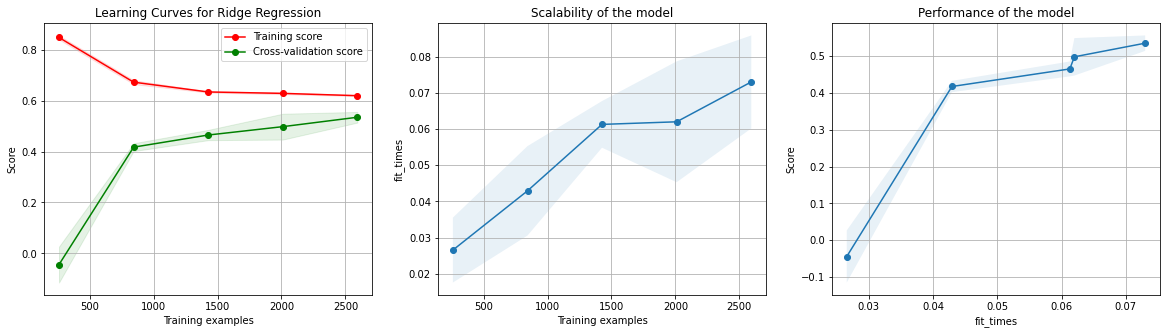

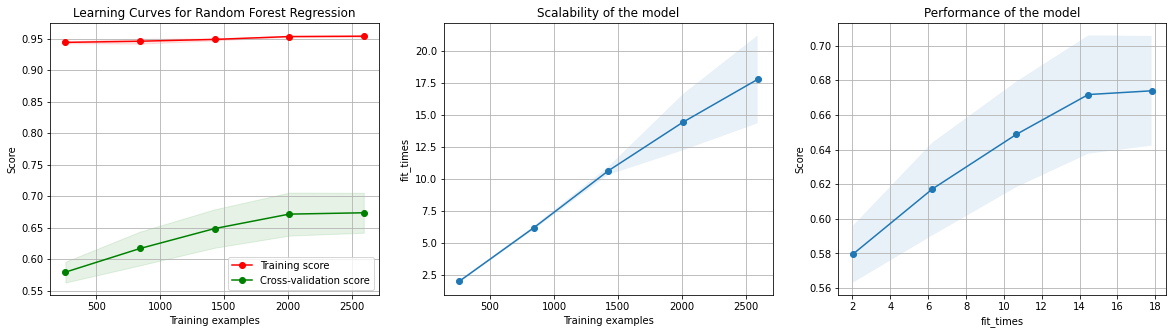

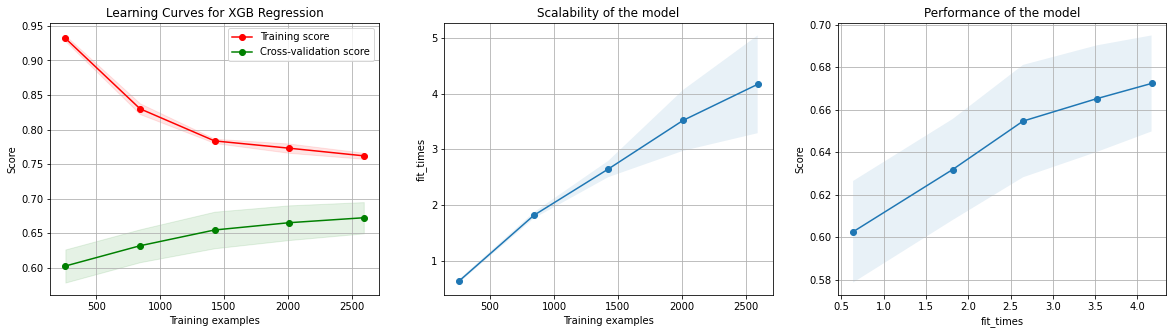

In [ ]:
# Ridge Regression:
title = r"Learning Curves for Ridge Regression"
estimator = Ridge()
plot_learning_curve(estimator, title, X_train_prepared, y_train, cv=5, n_jobs=5)

# Random Forest Regression:
title = r"Learning Curves for Random Forest Regression"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

# Gradient Boosting Regressor:
title = r"Learning Curves for XGB Regression"
estimator= xgb.XGBRegressor(objective ='reg:squarederror')
plot_learning_curve(estimator, title, X_train_prepared, y_train,cv=5, n_jobs=5)

plt.show()



**Fine tunning the model**

In [ ]:
# Applying GridSearchCV on the extreme gradient boost algorithm
xgb1 = xgb.XGBRegressor()

parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [7, 8, 9],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_prepared,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  9.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [7, 8, 9], 'min_child_weight': [4],
                         'n_estim

In [ ]:
# The best score and paramters
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7164762233633681
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [ ]:
# Predicting the prices with the test data
pred_x = xgb_grid.predict(X_test_prepared)

# Calculating the RMSE
mse = mean_squared_error(y_test,pred_x)
rmse = np.sqrt(mse)
rmse

0.3646780154753308

In [ ]:
pred_x

array([5.091869 , 5.026329 , 5.2249675, ..., 4.782664 , 6.2222047,
       4.8315887], dtype=float32)

**Feature Importance**


In [ ]:
# Final model and parameters
xgb2 = xgb.XGBRegressor(colsample_bytree = 0.7, 
                        learning_rate = 0.05, 
                        max_depth = 7, 
                        min_child_weight = 4, 
                        n_estimators = 500, 
                        nthread = 4, 
                        objective = 'reg:squarederror', 
                        silent = 1, 
                        subsample = 0.7)

xgb2.fit(X_train_prepared,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [ ]:
# feature importance scores
print(xgb2.feature_importances_)

[2.2411670e-03 6.5201637e-03 1.9493409e-03 3.3040042e-03 2.7757004e-02
 1.8943572e-02 1.6948006e-01 1.6112609e-02 4.0988019e-03 1.0525247e-02
 6.7581763e-03 5.9536579e-03 3.7296463e-03 3.7219306e-03 4.4691674e-03
 3.2682598e-03 1.1002066e-02 2.7498272e-03 3.2192317e-03 9.6404217e-03
 3.4182456e-03 3.0486253e-03 3.6083325e-03 3.0455964e-03 3.7432159e-03
 5.4067653e-03 2.4862774e-03 3.2293203e-03 1.4720119e-03 9.8081827e-03
 0.0000000e+00 0.0000000e+00 6.9044358e-03 1.9706541e-03 3.2441102e-03
 5.9003714e-03 2.0201785e-02 1.8819630e-02 2.3309016e-03 0.0000000e+00
 3.3607781e-03 9.2296361e-04 0.0000000e+00 3.3679928e-03 3.3577939e-03
 1.3087788e-02 0.0000000e+00 7.7911513e-03 5.8932472e-03 1.1859782e-03
 6.8413056e-03 4.7097392e-03 3.1281463e-03 4.3712477e-03 3.9162259e-03
 2.0320183e-03 0.0000000e+00 2.2232214e-03 2.7522610e-03 3.2222646e-03
 6.2237848e-03 2.8339932e-03 9.4235335e-03 2.3094960e-03 5.6212633e-03
 2.5518204e-03 0.0000000e+00 2.0266587e-03 1.0255081e-02 5.8787423e-03
 8.211

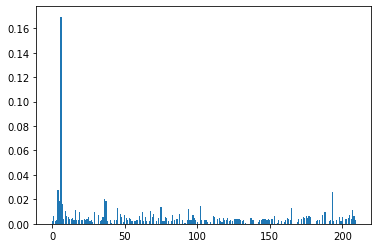

In [ ]:
# ploting the features importance scores
plt.bar(range(len(xgb2.feature_importances_)), xgb2.feature_importances_)
plt.show()

In [ ]:
# Creating the columns names of the data transformation
# cat_one_hot_attribs = cat_pipeline.named_steps()
attributes = num_attribs + list(cat_pipeline)

# Displaying the top ten feature importance scores
sorted(zip(xgb2.feature_importances_,attributes),reverse=True)[:10]

[(0.16948006, 'bedrooms'),
 (0.027757004, 'accommodates'),
 (0.026091987, 'tv'),
 (0.020201785, 'bath towel'),
 (0.018943572, 'bathrooms'),
 (0.01881963, 'bathroom essentials'),
 (0.016112609, 'beds'),
 (0.01465581, 'gym'),
 (0.013717328, 'elevator'),
 (0.013328857, 'shampoo')]

In [ ]:
# Display all of the feature importance scores in order from most important to least
ft_weights_xgb_reg = pd.DataFrame(xgb2.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending = False, inplace=True)
ft_weights_xgb_reg

,weight
bedrooms,0.169480
accommodates,0.027757
tv,0.026092
bath towel,0.020202
bathrooms,0.018944
...,...
steam oven,0.000000
ground floor access,0.000000
central air conditioning,0.000000
hammock,0.000000


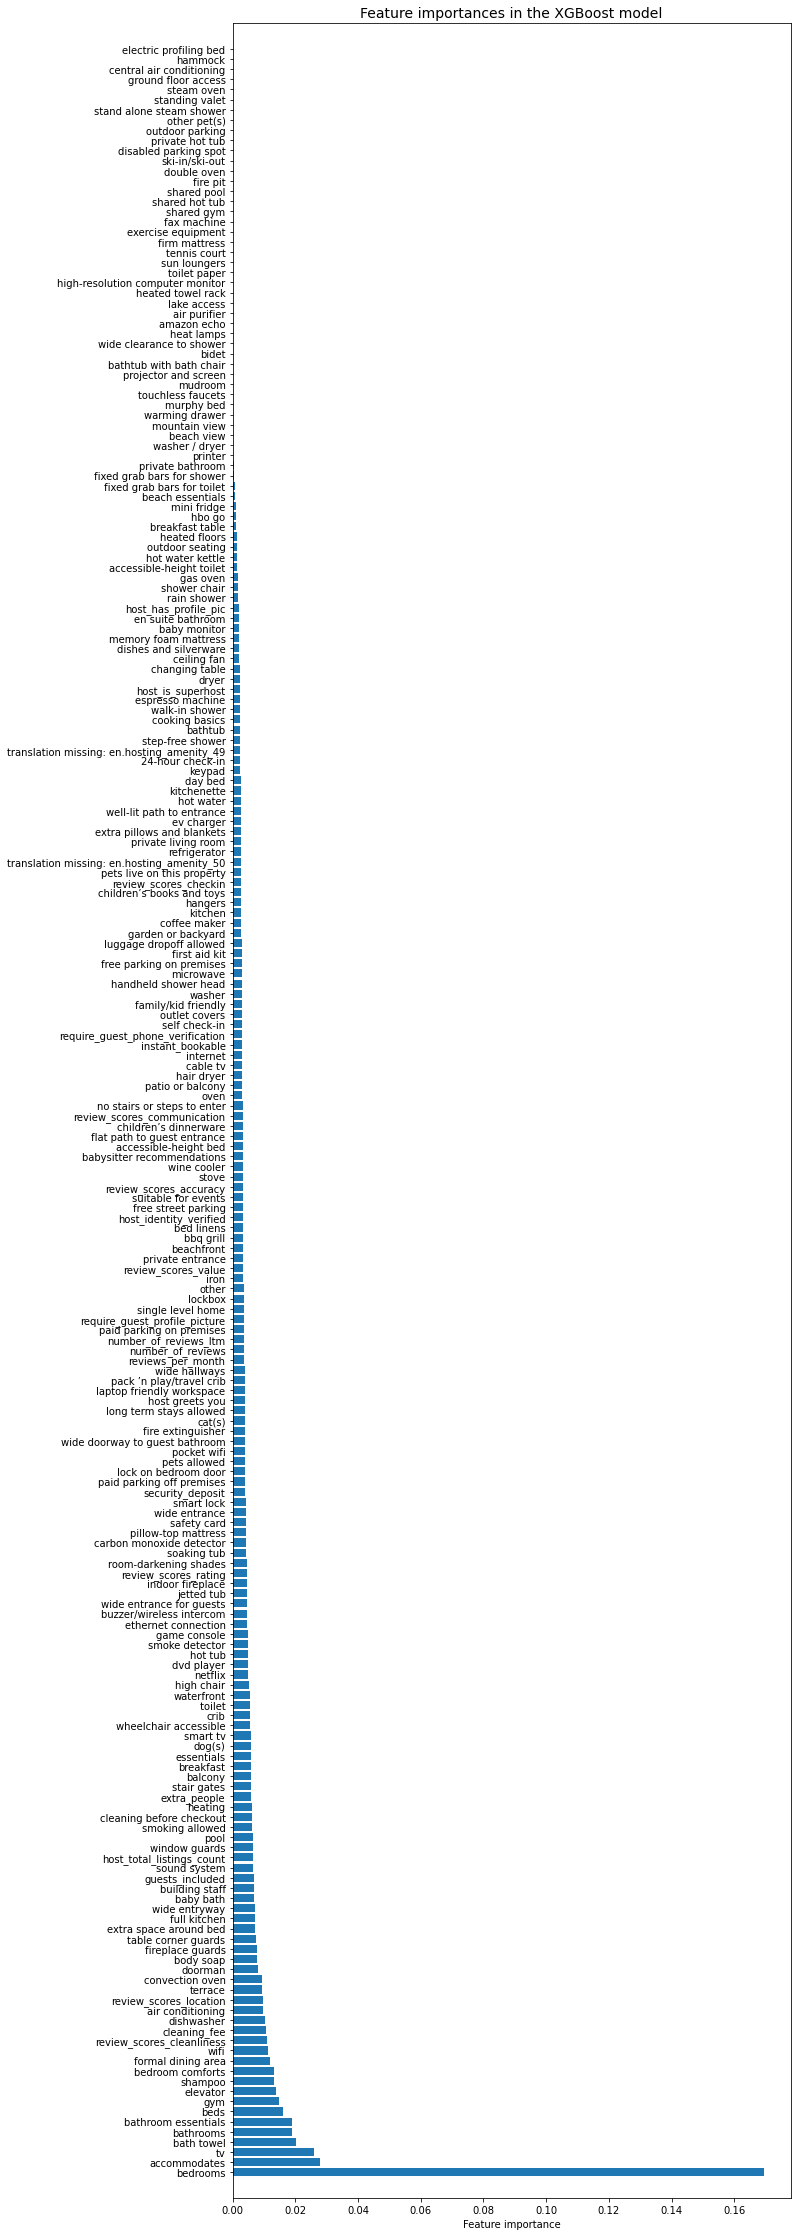

In [ ]:
# Plotting feature importances
plt.figure(figsize=(10,40))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()